In [56]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


In [57]:
line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [58]:
from ion_properties import ions,lead,calcium,xenon

ion=lead

In [59]:
# Ion properties:
q0 = ion.q0
mass0 = ion.mass0

gamma = ion.gamma_rel4
beta= np.sqrt(1-1/(gamma*gamma))
p0c = mass0*gamma*beta #eV/c

bunch_intensity = ion.Intensity

particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

line.particle_ref=particle_ref

In [60]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

nemitt = 0.7*1e-6
sigma_z = 0.063/2

emittance=nemitt/(beta*gamma)

num_particles=50000

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        particle_ref=particle_ref,
        line=line,        
        )

particles0=particles.copy()
# sigma_dp=2e-4  
sigma_dp=np.std(particles.delta)


In [61]:
sigma_dp

LinkedArrayCpu(0.00010083)

In [62]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
ion_excited_lifetime=ion.excited_lifetime
hw0 = ion.hw0 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = ion.lambda_l

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy = 5e-3

laser_x = ion.laser_x

GF_IP = xt.PulsedLaser(
                laser_x=laser_x,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 1
int_time_s = 0.01
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e3)
# save_interval = num_turns/100
# # save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)


line.discard_tracker()
IP_index=16675   
# line.insert_element('monitor', element=monitor, index=IP_index)
# line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  twiss.betx[IP_index]
beta_y  =  twiss.bety[IP_index]
alpha_x =  twiss.alfx[IP_index]
alpha_y =  twiss.alfy[IP_index]

gamma_x=twiss.gamx[IP_index]
gamma_y=twiss.gamy[IP_index]

Dx  =  twiss.dx[IP_index]
Dpx =  twiss.dpx[IP_index]

Dy  =  twiss.dy[IP_index]
Dpy =  twiss.dpy[IP_index]

Laser pulse duration sigma_t = 5.43 ps
Laser wavelength = 1031.80 nm


In [63]:
save_interval

433

In [64]:
emittance_x[-1]

7.125937883188393e-07

In [65]:
print("beta_x:", beta_x)
print("beta_y:", beta_y)
print("alpha_x:", alpha_x)
print("alpha_y:", alpha_y)
print("gamma_x:", gamma_x)
print("gamma_y:", gamma_y)
print("Dx:", Dx)
print("Dpx:", Dpx)
print("Dy:", Dy)
print("Dpy:", Dpy)


beta_x: 54.46611023891817
beta_y: 44.39557646380093
alpha_x: -1.5456070795347416
alpha_y: 1.3225757163115908
gamma_x: 0.062220432324179675
gamma_y: 0.06192523544814771
Dx: 2.3261652157336967
Dpx: 0.09359130580265473
Dy: -0.0
Dpy: -0.0


In [66]:
particles=particles0.copy()

context = xo.ContextCpu(omp_num_threads=4)
line.build_tracker(_context=context)
line.optimize_for_tracking()

# line.track(particles, num_turns=num_turns,
#               turn_by_turn_monitor=False,with_progress=True)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [67]:
from xibs.analytical import NagaitsevIBS
from xibs.inputs import BeamParameters, OpticsParameters
from xibs.kicks import IBSKickCoefficients, SimpleKickIBS

beamparams = BeamParameters.from_line(line, n_part=bunch_intensity)
opticsparams = OpticsParameters(twiss)

IBS = SimpleKickIBS(beamparams, opticsparams)
NIBS = NagaitsevIBS(beamparams, opticsparams)



# Define some parameters for the tracking
nturns = 1000  # number of turns to loop for
# nturns=2168766
# ibs_step = 21687  # frequency at which to re-compute the growth rates & kick coefficients in [turns]
ibs_step = 50

In [68]:
save_interval

433

In [69]:
def _bunch_length(parts: xp.Particles) -> float:
    return np.std(parts.zeta[parts.state > 0])


def _sigma_delta(parts: xp.Particles) -> float:
    return np.std(parts.delta[parts.state > 0])


def _geom_epsx(parts: xp.Particles, twiss: xt.TwissTable) -> float:
    """
    We index dx and betx at 0 which corresponds to the beginning / end of
    the line, since this is where / when we will be applying the kicks.
    """
    sigma_x = np.std(parts.x[parts.state > 0])
    sig_delta = _sigma_delta(parts)
    return (sigma_x**2 - (twiss["dx"][0] * sig_delta) ** 2)*(beta*gamma) / twiss["betx"][0]


def _geom_epsy(parts: xp.Particles, twiss: xt.TwissTable) -> float:
    """
    We index dy and bety at 0 which corresponds to the beginning / end of
    the line, since this is where / when we will be applying the kicks.
    """
    sigma_y = np.std(parts.y[parts.state > 0])
    sig_delta = _sigma_delta(parts)
    return (sigma_y**2 - (twiss["dy"][0] * sig_delta) ** 2)*(beta*gamma) / twiss["bety"][0]

In [70]:
import logging
import sys
import warnings

from dataclasses import dataclass
from typing import Self

import matplotlib.pyplot as plt
import numpy as np
import xobjects as xo
import xpart as xp
import xtrack as xt

from xibs.analytical import NagaitsevIBS
from xibs.inputs import BeamParameters, OpticsParameters
from xibs.kicks import IBSKickCoefficients, SimpleKickIBS


@dataclass
class Records:
    epsilon_x: np.ndarray
    epsilon_y: np.ndarray
    sigma_delta: np.ndarray
    bunch_length: np.ndarray

    def update_at_turn(self, turn: int, parts: xp.Particles, twiss: xt.TwissTable):
        """Automatically update the records at given turn from the xpart.Particles."""
        self.epsilon_x[turn] = _geom_epsx(parts, twiss)
        self.epsilon_y[turn] = _geom_epsy(parts, twiss)
        self.sigma_delta[turn] = _sigma_delta(parts)
        self.bunch_length[turn] = _bunch_length(parts)

    @classmethod
    def init_zeroes(cls, n_turns: int) -> Self:  # noqa: F821
        """Initialize the dataclass with arrays of zeroes."""
        return cls(
            epsilon_x=np.zeros(n_turns, dtype=float),
            epsilon_y=np.zeros(n_turns, dtype=float),
            sigma_delta=np.zeros(n_turns, dtype=float),
            bunch_length=np.zeros(n_turns, dtype=float),
        )


# Initialize the dataclasses
kicked_tbt = Records.init_zeroes(nturns)
analytical_tbt = Records.init_zeroes(nturns)

# Store the initial values
kicked_tbt.update_at_turn(0, particles, twiss)
analytical_tbt.update_at_turn(0, particles, twiss)

# Let's hide anything below WARNING level for readability
logging.basicConfig(
    level=logging.WARNING,
    stream=sys.stdout,
    format="[%(asctime)s] [%(levelname)s] - %(module)s.%(funcName)s:%(lineno)d - %(message)s",
    datefmt="%H:%M:%S",
    force=True,
)

In [71]:
# # We loop here now
# for turn in tqdm(range(1, nturns)):
#     # ----- Potentially re-compute the IBS growth rates and kick coefficients ----- #
#     if (turn % ibs_step == 0) or (turn == 1):
#         #print(f"Turn {turn:d}: re-computing growth rates and kick coefficients")
#         # Compute kick coefficients from the particle distribution at this moment
#         IBS.compute_kick_coefficients(particles)
#         # Compute analytical values from those at the previous turn
#         NIBS.growth_rates(
#             analytical_tbt.epsilon_x[turn - 1],
#             analytical_tbt.epsilon_y[turn - 1],
#             analytical_tbt.sigma_delta[turn - 1],
#             analytical_tbt.bunch_length[turn - 1],
#         )
#         #monitor.track(particles)
#     #else:
#         #print(f"Turn {turn:d}")

#     # ----- Manually Apply IBS Kick and Track Turn ----- #
#     IBS.apply_ibs_kick(particles)
#     line.track(particles, num_turns=1)

#     # ----- Update records for tracked particles ----- #
#     kicked_tbt.update_at_turn(turn, particles, twiss)

#     # ----- Compute analytical Emittances from previous turn values & update records----- #
#     ana_emit_x, ana_emit_y, ana_sig_delta, ana_bunch_length = NIBS.emittance_evolution(
#         analytical_tbt.epsilon_x[turn - 1],
#         analytical_tbt.epsilon_y[turn - 1],
#         analytical_tbt.sigma_delta[turn - 1],
#         analytical_tbt.bunch_length[turn - 1],
#     )
#     analytical_tbt.epsilon_x[turn] = ana_emit_x
#     analytical_tbt.epsilon_y[turn] = ana_emit_y
#     analytical_tbt.sigma_delta[turn] = ana_sig_delta
#     analytical_tbt.bunch_length[turn] = ana_bunch_length

In [72]:
save_interval

433

In [73]:
# Initialize empty lists to store values
x_values = []
px_values = []
y_values = []
py_values = []
delta_values = []
zeta_values = []
state_values = []
action_x_values = []
action_y_values = []

emittance_x_values = []
emittance_y_values = []

rms_dp_p_values=[]

gamma_x=(1+alpha_x**2)/beta_x
gamma_y=(1+alpha_y**2)/beta_y


# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 2
int_time_s = 0.01
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# Iterate over turns
for turn in tqdm(range(1, num_turns)):
    # ----- Potentially re-compute the IBS growth rates and kick coefficients ----- #
    line.track(particles, num_turns=1, turn_by_turn_monitor=False)
    
    if (turn % ibs_step == 0) or (turn == 1):
        # Compute kick coefficients from the particle distribution at this moment
        IBS.compute_kick_coefficients(particles)       
        IBS.apply_ibs_kick(particles)
        
        if turn % save_interval == 0:  # Check if it's time to save
            # Append copies of all attributes to their respective lists
            x_values.append(particles.x.copy())
            px_values.append(particles.px.copy())
            y_values.append(particles.y.copy())
            py_values.append(particles.py.copy())
            delta_values.append(particles.delta.copy())
            zeta_values.append(particles.zeta.copy())
            state_values.append(particles.state.copy())
            
            # Calculate actions and append to their respective lists
            action_x = (gamma_x * (particles.x - Dx * particles.delta)**2 +
                        2 * alpha_x * (particles.x - Dx * particles.delta) * (particles.px - Dpx * particles.delta) +
                        beta_x * (particles.px - Dpx * particles.delta)**2)
            action_y = (gamma_y * (particles.y - Dy * particles.delta)**2 +
                        2 * alpha_y * (particles.y - Dy * particles.delta) * (particles.py - Dpy * particles.delta) +
                        beta_y * (particles.py - Dpy * particles.delta)**2)
            action_x_values.append(action_x.copy())
            action_y_values.append(action_y.copy())
            emittance_x_values.append(np.mean(action_x.copy()))
            emittance_y_values.append(np.mean(action_y.copy()))

            rms_dp_p_values.append(np.std(particles.delta.copy()))

# Save all the collected data into the .npz file
np.savez('results_IBS_kicks/lead.npz', 
         x=x_values, 
         px=px_values, 
         y=y_values, 
         py=py_values, 
         delta=delta_values, 
         zeta=zeta_values, 
         state=state_values, 
         action_x=action_x_values, 
         action_y=action_y_values, 
         emittance_x=emittance_x_values, 
         emittance_y=emittance_y_values, 
         rms_dp_p=rms_dp_p_values)  

          

100%|██████████| 86746/86746 [24:06:13<00:00,  1.00s/it]   


In [74]:
emittance_x_twiss


array([1.50621295e-06, 1.48807524e-06, 1.46997331e-06, 1.45183240e-06,
       1.43378153e-06, 1.41637311e-06, 1.39984051e-06, 1.38349355e-06,
       1.36694474e-06, 1.35075535e-06, 1.33529092e-06, 1.32031032e-06,
       1.30554041e-06, 1.29079015e-06, 1.27627190e-06, 1.26257673e-06,
       1.24966342e-06, 1.23681170e-06, 1.22385775e-06, 1.21129692e-06,
       1.19935342e-06, 1.18786495e-06, 1.17649524e-06, 1.16505407e-06,
       1.15390420e-06, 1.14355807e-06, 1.13374172e-06, 1.12381494e-06,
       1.11377908e-06, 1.10407793e-06, 1.09491191e-06, 1.08606985e-06,
       1.07716713e-06, 1.06812778e-06, 1.05945398e-06, 1.05148182e-06,
       1.04378932e-06, 1.03584404e-06, 1.02777883e-06, 1.02004247e-06,
       1.01277304e-06, 1.00566997e-06, 9.98355056e-07, 9.90931039e-07,
       9.83938620e-07, 9.77534290e-07, 9.71192096e-07, 9.64503979e-07,
       9.57733758e-07, 9.51328953e-07, 9.45307858e-07, 9.39294364e-07,
       9.32999954e-07, 9.26679532e-07, 9.20838626e-07, 9.15462048e-07,
      

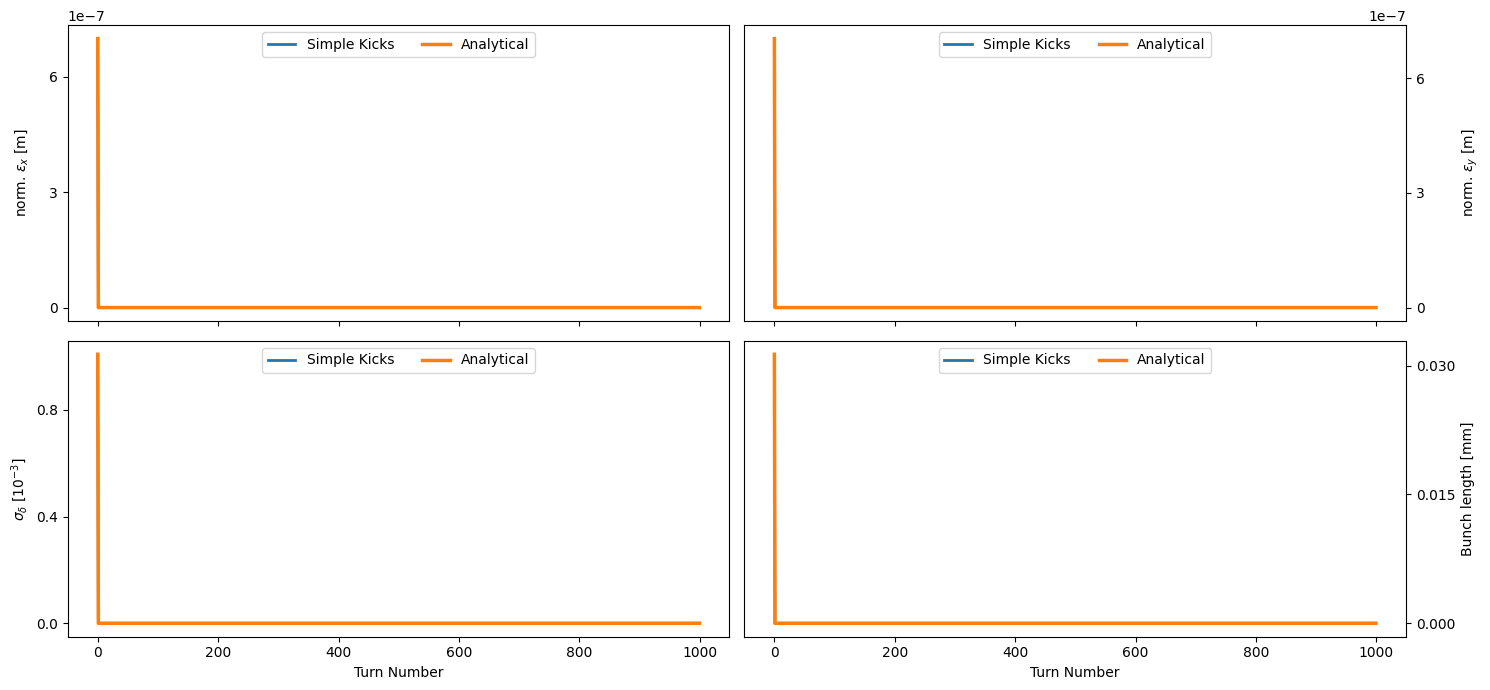

In [75]:
turns = np.arange(nturns, dtype=int)  # array of turns
fig, axs = plt.subplot_mosaic([["epsx", "epsy"], ["sigd", "bl"]], sharex=True, figsize=(15, 7))

# Plot from tracked & kicked particles
axs["epsx"].plot(turns, kicked_tbt.epsilon_x , lw=2, label="Simple Kicks")
axs["epsy"].plot(turns, kicked_tbt.epsilon_y , lw=2, label="Simple Kicks")
axs["sigd"].plot(turns, kicked_tbt.sigma_delta *1e4 , lw=2, label="Simple Kicks")
axs["bl"].plot(turns, kicked_tbt.bunch_length , lw=2, label="Simple Kicks")

# Plot from analytical values
axs["epsx"].plot(turns, analytical_tbt.epsilon_x , lw=2.5, label="Analytical")
axs["epsy"].plot(turns, analytical_tbt.epsilon_y , lw=2.5, label="Analytical")
axs["sigd"].plot(turns, analytical_tbt.sigma_delta *1e4 , lw=2.5, label="Analytical")
axs["bl"].plot(turns, analytical_tbt.bunch_length , lw=2.5, label="Analytical")

# Axes parameters
axs["epsx"].set_ylabel(r"norm. $\varepsilon_x$ [m]")
axs["epsy"].set_ylabel(r"norm. $\varepsilon_y$ [m]")
axs["sigd"].set_ylabel(r"$\sigma_{\delta}$ [$10^{-3}$]")
axs["bl"].set_ylabel(r"Bunch length [mm]")

for axis in (axs["epsy"], axs["bl"]):
    axis.yaxis.set_label_position("right")
    axis.yaxis.tick_right()

for axis in (axs["sigd"], axs["bl"]):
    axis.set_xlabel("Turn Number")

for axis in axs.values():
    axis.yaxis.set_major_locator(plt.MaxNLocator(3))
    axis.legend(loc=9, ncols=4)

fig.align_ylabels((axs["epsx"], axs["sigd"]))
fig.align_ylabels((axs["epsy"], axs["bl"]))

plt.tight_layout()
plt.show()

In [76]:
analytical_tbt.epsilon_x[0]

6.987615096293727e-07

In [77]:
# # extract relevant values
# x = monitor.x[:,:,0]
# px = monitor.px[:,:,0]
# y = monitor.y[:,:,0]
# py = monitor.py[:,:,0]
# delta = monitor.delta[:,:,0]
# zeta = monitor.zeta[:,:,0]
# state = monitor.state[:,:,0]
# time = monitor.at_turn[:, 0, 0] * T_per_turn


# action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
# action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

# emittance_x_twiss=np.mean(action_x,axis=1)*gamma/2

# np.savez(f'results_IBS_kicks/{ion.name}.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta,
# action_x=action_x,action_y=action_y,emittance_x=emittance_x_twiss,
# state=state, time=time,s_per_turn=T_per_turn)

In [78]:
print(len(x))

100


Transverse emittance

In [79]:
# plt.figure(figsize=(12, 8))
# plt.rcParams.update({'font.size': 25})
# plt.plot(emittance_x_twiss)
# plt.xlabel('time [s]')
# plt.ylabel('emittance x ')
# plt.title('action averaging emittance')
# ax = plt.gca()
# # Removing the offset from the y-axis tick labels
# ax.yaxis.get_major_formatter().set_useOffset(False)
# # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.show()